In [1]:
%matplotlib inline

In [2]:
# stdlib imports
from datetime import datetime
from time import time

# Third party imports
import matplotlib.pyplot as plt
from obspy.geodetics.base import gps2dist_azimuth
import pandas as pd

# Local imports
from libcomcat.dataframes import get_history_data_frame
from libcomcat.search import (get_event_by_id, get_authoritative_info, search)

# Comparing network magnitudes/locations/depths
----

Using ComCat, differences between network magnitude, location, and depth can be determined. The cells below use a method, *get_authoritative_info()* that can take a fair amount of time to run, so if you are not doing your own analysis, take note of the documentation above the cell where data is downloaded and run the cell after it instead.

In this example, magnitudes, locations, and depths from the Lamont-Doherty (LD) seismic network will be compared with their equivalents from the National Earthquake Information Center (NEIC/US).

## Contents
----
- [Getting Events](#Getting-Events)
- [Creating a Dataframe from an Excel Spreadsheet](#Creating-a-Dataframe-from-an-Excel-Spreadsheet)
- [Getting-Magnitudes-from-a-Specific-Catalog](#Getting-Magnitudes-from-a-Specific-Catalog)

In [3]:
# VERY approximate Lamont Doherty network bounds
bounds = [-81.762695, -66.953125, 37.356678, 47.780544]

# start/end times for analysis
stime = datetime(2017,1,1)
etime = datetime.utcnow()

# magnitude range
minmag = 0.0
maxmag = 9.9

## Getting Events
### Only run this cell if you have time to wait for downloads!

In this cell, a list of SummaryEvent objects is downloaded. For each one, the *get_authoritative_info()* function is called to retrieve the authoritative magnitudes, locations and depths from each contributing network. Then that information is assembled into a pandas DataFrame to be used for our analysis.

In [4]:
# Retrieve list of events
eventlist = search(starttime=stime,
                  endtime=etime,
                  minlatitude=bounds[2],
                  maxlatitude=bounds[3],
                  minlongitude=bounds[0],
                  maxlongitude=bounds[1],
                  minmagnitude=minmag,
                  maxmagnitude=maxmag)
print(len(eventlist))

# Retrieve all mag/locations for those events 
# (depending on bandwidth), this can take 30 
# seconds to a minute per event.
t1 = time()
magdict = {}
columns = []
for event in eventlist:
    mdict, ldict, _ = get_authoritative_info(event.id)
    mdict.update(ldict)
    magdict[event.id] = mdict
    columns += list(mdict.keys())
    
t2 = time()
dt = t2-t1
fmt = 'Elapsed time to retrieve %i magnitudes: %.2f seconds'
print(fmt % (len(eventlist),dt))

# Assemble these dictionaries into a DataFrame
columns = ['eventid'] + list(set(columns))
dataframe = pd.DataFrame(columns=columns)
for eventid, edict in magdict.items():
    edict['eventid'] = eventid
    dataframe = dataframe.append(edict, ignore_index=True)

409
Elapsed time to retrieve 409 magnitudes: 270.47 seconds


## Creating a Dataframe from an Excel Spreadsheet
### If presenting, run this cell instead

This cell loads a previously downloaded table of information.

In [5]:
tablefile = './data/events.xlsx'
if 'dataframe' not in vars():
    dataframe = pd.read_excel(tablefile)
else:
    dataframe.to_excel(tablefile, index=False)

The *count()* method on a DataFrame is a convenient way to see how many non-null values are in each column of the DataFrame.

In [6]:
dataframe.count()

eventid         409
se-latitude      20
us-mwr            3
us-depth        348
us-NA             0
se-longitude     20
us-ml           220
us-latitude     348
us-mb             1
ld-depth        163
se-mlg            1
ld-longitude    163
se-depth         20
us-mb_lg         37
ld-latitude     163
us-longitude    348
se-md            19
ld-ml           163
dtype: int64

# Getting Magnitudes from a Specific Catalog
In the cell below, the ML magnitudes from LD and US are gathered and plotted against each other. The resulting figure shows that US ML magnitudes are consistently higher than the LD equivalents.

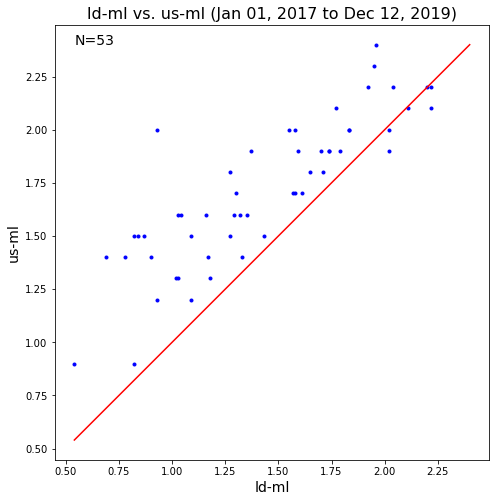

In [7]:
reg_type = 'ld-ml'
us_type = 'us-ml'
c1 = dataframe[reg_type].notnull()
c2 = dataframe[us_type].notnull()
N = len(dataframe[c1&c2])
magdf = dataframe[c1&c2]
reg_mag = magdf[reg_type]
us_mag = magdf[us_type]
minmag = min(reg_mag.min(),us_mag.min())
maxmag = max(reg_mag.max(),us_mag.max())
fig = plt.figure(figsize=(8,8))
plt.plot(reg_mag, us_mag,'b.');
plt.plot([minmag,maxmag],[minmag,maxmag],'r');
# plt.axes([minmag,maxmag,minmag,maxmag]);
plt.axis('square');
plt.xlabel(reg_type, fontsize=14);
plt.ylabel(us_type, fontsize=14);
plt.text(minmag, maxmag, 'N=%i' % N, fontsize=14);
sdate = stime.strftime('%b %d, %Y')
edate = etime.strftime('%b %d, %Y')
fmt = '%s vs. %s (%s to %s)'
plt.title(fmt % (reg_type, us_type, sdate, edate), fontsize=16);

In the cell below, the US and LD latitude/longitude values are assembled, and the distances between them are calculated.

In [8]:
regname = 'ld'
lat1col = '%s-latitude' % regname
lon1col = '%s-longitude' % regname
lat2col = 'us-latitude'
lon2col = 'us-longitude'
c1 = dataframe[lat1col].notnull()
c2 = dataframe[lon1col].notnull()
c3 = dataframe[lat2col].notnull()
c4 = dataframe[lon2col].notnull()
locdf = dataframe[c1 & c2 & c3 & c4].copy()
distances = []
for idx, row in locdf.iterrows():
    lat1 = row[lat1col]
    lon1 = row[lon1col]
    lat2 = row[lat2col]
    lon2 = row[lon2col]
    dist, az1, az2 = gps2dist_azimuth(lat1, lon1, lat2, lon2)
    distances.append(dist/1000.0)

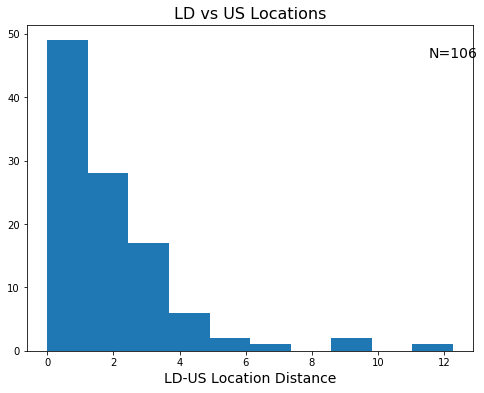

In [9]:
fig = plt.figure(figsize=(8,6));
plt.hist(distances, bins=10);
plt.xlabel('LD-US Location Distance', fontsize=14);
xmin,xmax,ymin,ymax = plt.axis();
xpos = xmax - (xmax-xmin)/10
ypos = ymax - (ymax-ymin)/10
plt.text(xpos,ypos,'N=%i' % len(distances), fontsize=14);
plt.title('LD vs US Locations', fontsize=16);

In this cell the LD magnitudes are plotted against the *difference* between US and LD calculated depths.

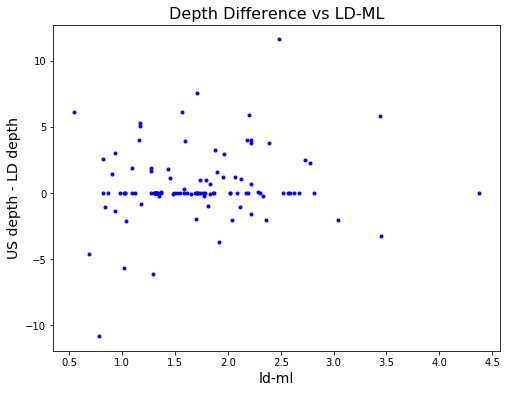

In [10]:
plt.figure(figsize=(8,6));
regcol = 'ld-depth'
uscol = 'us-depth'
ddepth = locdf[uscol] - locdf[regcol]
plt.plot(locdf['ld-ml'],ddepth,'b.');
plt.xlabel('ld-ml', fontsize=14);
plt.ylabel('US depth - LD depth', fontsize=14);
plt.title('Depth Difference vs LD-ML', fontsize=16);